<h1> Modelagem Inicial </h1>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [14]:
# Leitura de arquivo CSV
df = pd.read_csv('acoes_vivo.csv', parse_dates=['Date'], index_col='Date')
#df.head()
df.tail()

,Symbol,Open,High,Low,Close,Volume
Date,,,,,,
2024-11-11 00:00:00-03:00,VIVT3.SA,51.900002,53.080002,51.599998,53.000000,1660600
2024-11-12 00:00:00-03:00,VIVT3.SA,52.529999,53.200001,52.009998,52.250000,2365500
2024-11-13 00:00:00-03:00,VIVT3.SA,52.130001,52.500000,51.740002,52.060001,1708900
2024-11-14 00:00:00-03:00,VIVT3.SA,52.060001,52.389999,51.599998,51.599998,1687200
2024-11-18 00:00:00-03:00,VIVT3.SA,51.540001,51.799999,51.160000,51.570000,1857200


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1245 entries, 2019-11-18 00:00:00-03:00 to 2024-11-18 00:00:00-03:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Symbol  1245 non-null   object 
 1   Open    1245 non-null   float64
 2   High    1245 non-null   float64
 3   Low     1245 non-null   float64
 4   Close   1245 non-null   float64
 5   Volume  1245 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 68.1+ KB


In [16]:
# valor de fechamento eh o target, demais valores sao features
X = df[["Open", "High", "Low", "Volume"]]
y = df["Close"]

# Divisao 80/20
test_size = 0.2

# `shuffle=False` para manter a ordem temporal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

print("Tamanho do treino:", len(X_train))
print("Tamanho do teste:", len(X_test))

# printando indices de treino e teste min e max
print(X_train.index[0], X_train.index[-1])
print(X_test.index[0], X_test.index[-1])

Tamanho do treino: 996
Tamanho do teste: 249
2019-11-18 00:00:00-03:00 2023-11-22 00:00:00-03:00
2023-11-23 00:00:00-03:00 2024-11-18 00:00:00-03:00


In [17]:
# Normalizacao usando min-max

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

print("Primeiros valores normalizados (X_train):", X_train_scaled[:5])
print("Primeiros valores normalizados (y_train):", y_train_scaled[:5].flatten())

Primeiros valores normalizados (X_train): [[7.78692016e-02 8.27188164e-02 1.14972937e-01 7.59999093e-04]
 [1.18429446e-01 7.82674906e-02 9.84711644e-02 4.60536764e-03]
 [7.40953057e-02 4.04320268e-02 7.96773004e-02 4.25372626e-04]
 [7.64541338e-02 4.31032757e-02 9.20539511e-02 3.00596656e-04]
 [5.52309094e-02 3.10854054e-02 8.15116350e-02 2.83581751e-05]]
Primeiros valores normalizados (y_train): [0.12425542 0.07196539 0.0715063  0.06462649 0.06004003]


In [18]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, sequence_length):
        self.X = X
        self.y = y
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.X) - self.sequence_length

    def __getitem__(self, idx):
        # Cria a sequência de entrada e o próximo valor como target
        x_seq = self.X[idx: idx + self.sequence_length]
        y_seq = self.y[idx + self.sequence_length]
        return torch.tensor(x_seq, dtype=torch.float32), torch.tensor(y_seq, dtype=torch.float32)

# Definir o comprimento da sequência
sequence_length = 10

# Criar datasets de treino e teste
train_dataset = TimeSeriesDataset(X_train_scaled, y_train_scaled, sequence_length)
test_dataset = TimeSeriesDataset(X_test_scaled, y_test_scaled, sequence_length)

# Criar DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Tamanho do dataset de treino: {len(train_dataset)}")
print(f"Tamanho do dataset de teste: {len(test_dataset)}")

Tamanho do dataset de treino: 986
Tamanho do dataset de teste: 239


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: [batch_size, sequence_length, input_size]
        out, (h_n, c_n) = self.lstm(x)  # Saída do LSTM
        out = self.fc(out[:, -1, :])    # Apenas o último estado oculto
        return out

LSTMModel(
  (lstm): LSTM(4, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
# Função de perda
criterion = nn.MSELoss()

# Função para calcular métricas
def calculate_metrics(y_true, y_pred):
    mae = np.mean(np.abs(y_true - y_pred))  # Mean Absolute Error
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))  # Root Mean Square Error
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
    return mae, rmse, mape

In [ ]:
# Hiperparâmetros
input_size = X_train_scaled.shape[1]
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 50
learning_rate = 0.001

# Inicializar o modelo, otimizador e função de perda
model = LSTMModel(input_size, hidden_size, num_layers, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

# Loop de treinamento
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validação
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/50, Train Loss: 0.0385, Val Loss: 0.0559
Epoch 2/50, Train Loss: 0.0070, Val Loss: 0.0055
Epoch 3/50, Train Loss: 0.0046, Val Loss: 0.0058
Epoch 4/50, Train Loss: 0.0043, Val Loss: 0.0067
Epoch 5/50, Train Loss: 0.0039, Val Loss: 0.0060
Epoch 6/50, Train Loss: 0.0039, Val Loss: 0.0096
Epoch 7/50, Train Loss: 0.0037, Val Loss: 0.0060
Epoch 8/50, Train Loss: 0.0035, Val Loss: 0.0042
Epoch 9/50, Train Loss: 0.0033, Val Loss: 0.0047
Epoch 10/50, Train Loss: 0.0035, Val Loss: 0.0059
Epoch 11/50, Train Loss: 0.0032, Val Loss: 0.0047
Epoch 12/50, Train Loss: 0.0032, Val Loss: 0.0051
Epoch 13/50, Train Loss: 0.0030, Val Loss: 0.0039
Epoch 14/50, Train Loss: 0.0029, Val Loss: 0.0032
Epoch 15/50, Train Loss: 0.0029, Val Loss: 0.0042
Epoch 16/50, Train Loss: 0.0029, Val Loss: 0.0035
Epoch 17/50, Train Loss: 0.0029, Val Loss: 0.0087
Epoch 18/50, Train Loss: 0.0026, Val Loss: 0.0027
Epoch 19/50, Train Loss: 0.0026, Val Loss: 0.0028
Epoch 20/50, Train Loss: 0.0026, Val Loss: 0.0031
Epoch 21/

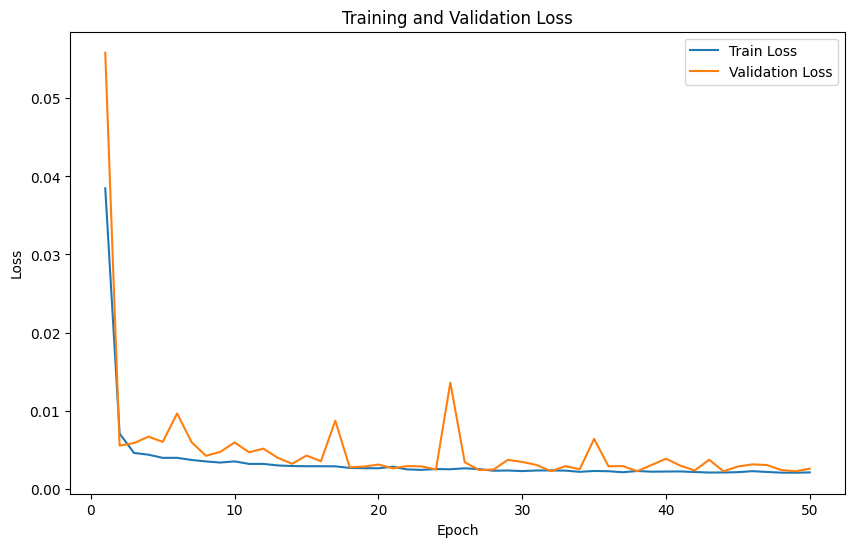

In [22]:
# Curva de Treinamento e Validação
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [23]:
model.eval()
test_loss = 0.0
predictions, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

        predictions.extend(outputs.numpy())
        actuals.extend(y_batch.numpy())

test_loss /= len(test_loader)
print(f"Test Loss (MSE): {test_loss:.4f}")

# Reverter normalização
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1))

# Calcular métricas
mae, rmse, mape = calculate_metrics(actuals, predictions)
print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

Test Loss (MSE): 0.0026
MAE: 0.6249, RMSE: 0.8209, MAPE: 1.25%


In [24]:
# Salvar o modelo
torch.save(model.state_dict(), "lstm_stock_model.pth")
print("Modelo salvo em 'lstm_stock_model.pth'")

joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")
print("Scalers salvos como 'scaler_X.pkl' e 'scaler_y.pkl'")

Modelo salvo em 'lstm_stock_model.pth'
Scalers salvos como 'scaler_X.pkl' e 'scaler_y.pkl'


In [25]:
# Carregar o modelo
model_loaded = LSTMModel(input_size, hidden_size, num_layers, output_size)
model_loaded.load_state_dict(torch.load("lstm_stock_model.pth"))
model_loaded.eval()

# Fazer previsões
with torch.no_grad():
    new_predictions = model_loaded(torch.tensor(X_test_scaled[-sequence_length:], dtype=torch.float32).unsqueeze(0))
    new_predictions = scaler_y.inverse_transform(new_predictions.numpy())
    print("Nova previsão:", new_predictions)

Nova previsão: [[50.88968]]


C:\Users\gufer\AppData\Local\Temp\ipykernel_83616\3430335520.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_loaded.load_state_dict(torch.load("lstm_stock_model.pt

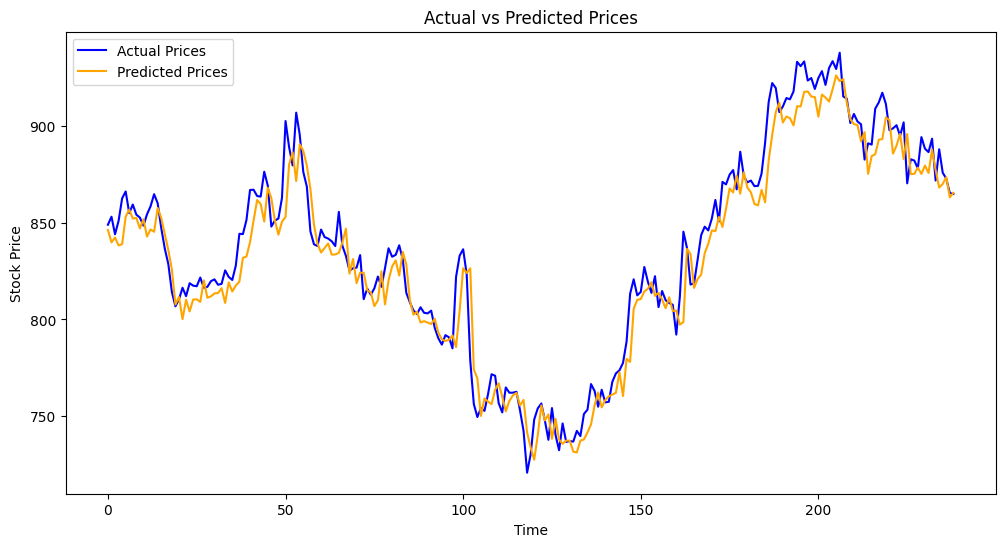

In [26]:
# Previsto VS. Real

# Reverter a normalização para previsões e valores reais
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1))

# Plotar os valores reais e previstos
plt.figure(figsize=(12, 6))
plt.plot(actuals, label="Actual Prices", color="blue")
plt.plot(predictions, label="Predicted Prices", color="orange")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs Predicted Prices")
plt.legend()
plt.show()